# Testing Different Normalizations for Print Quality:
## Scoares normalized between 10 to 90

# Take this

In [14]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Load dataset
file_path = 'data_with_metrics.csv'
data = pd.read_csv(file_path)
data.replace("Fail", np.nan, inplace=True)

# Identify relevant features
layer_columns = [col for col in data.columns if "Layer" in col and "Deviation" in col]
geometric_features = [
    'total_height_deviation', 'Angle_dev (deg)', 'Max Span (mm)'
] + layer_columns

# Ensure all geometric features are numeric
for feature in geometric_features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')

# Filter valid rows (only complete ones)
valid_rows = data[geometric_features + ['layer_var', 'Speed (mm/s)', 'Flowrate (cm^3/s)']].dropna()

# Prepare features and target
X = valid_rows[geometric_features]
y = valid_rows['layer_var']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Feature importances → Weights
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Combined metric calculator
weights = feature_importance_df['Weight'].values

def calculate_combined_metric(row, features, weights):
    combined_metric = 10
    for i in range(len(features)):
        feature = features[i]
        weight = weights[i]
        value = row[feature]

        if 'Deviation' in feature or 'height_cv' in feature:
            combined_metric += value * weight
        elif 'Span' in feature:
            if value > 0:
                combined_metric -= value * weight
        elif 'Angle' in feature:
            if value > 0:
                combined_metric += value * weight

    return max(10, combined_metric)

# Apply combined metric
valid_rows['Combined_Metric'] = valid_rows.apply(lambda row: calculate_combined_metric(row, geometric_features, weights), axis=1)

# Normalize combined metric to a 10–90 scale (reverse: lower is better)
min_metric = valid_rows['Combined_Metric'].min()
max_metric = valid_rows['Combined_Metric'].max()
valid_rows['Normalized_Score'] = valid_rows['Combined_Metric'].apply(
    lambda x: (1 - (x - min_metric) / (max_metric - min_metric)) * 80 + 10
)

# Classify print quality
def classify_print(score, good_threshold, bad_threshold):
    if score >= good_threshold:
        return "Good Print"
    elif score <= bad_threshold:
        return "Poor Print"
    else:
        return "Moderate Print"

good_threshold = valid_rows['Normalized_Score'].quantile(0.75)
bad_threshold = valid_rows['Normalized_Score'].quantile(0.25)

valid_rows['Print_Quality'] = valid_rows['Normalized_Score'].apply(
    lambda x: classify_print(x, good_threshold, bad_threshold)
)

# Select and export
output = valid_rows[['Speed (mm/s)', 'Flowrate (cm^3/s)', 'Combined_Metric', 'Normalized_Score', 'Print_Quality']]
output.to_csv('classified_print_quality_final.csv', index=False)
print("Saved to classified_print_quality_final.csv")


Saved to classified_print_quality_final.csv


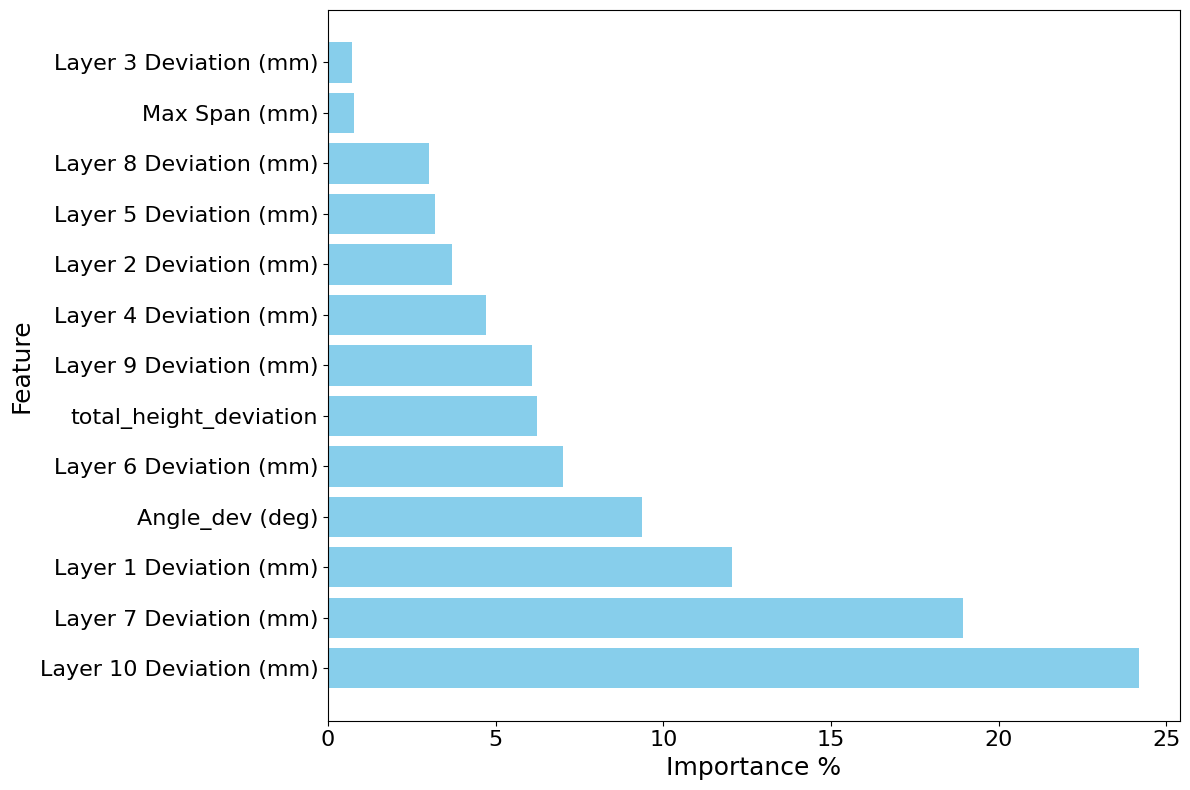

In [15]:
import matplotlib.pyplot as plt

# Sort by importance just in case
feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)

# Horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

# Set larger font sizes
plt.xlabel('Importance %', fontsize=18)
plt.ylabel('Feature', fontsize=18)
#plt.title('Feature Importances', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.gca().invert_yaxis()  # Most important feature on top
plt.savefig('Feature_Importance.png')
plt.show()


## SHAP

In [17]:
import shap
import matplotlib.pyplot as plt
import os

# Create SHAP directory
shap_dir = "SHAP"
os.makedirs(shap_dir, exist_ok=True)

# Initialize SHAP (for Jupyter interactivity)
shap.initjs()

# Generate SHAP explainer and values (if not done)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# --- 1. Summary Bar Plot ---
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Value per Feature", fontsize=14, weight='bold')
plt.xlabel("Mean |SHAP value| (Impact on Prediction)", fontsize=14)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"{shap_dir}/1_shap_summary_bar.jpg", dpi=300, format='jpg')
plt.close()

# --- 2. Beeswarm Plot ---
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Distribution of SHAP Values Across Features", fontsize=14, weight='bold')
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=14)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"{shap_dir}/2_shap_beeswarm.jpg", dpi=300, format='jpg')
plt.close()

# --- 3. Dependence Plot ---
key_feature = 'total_height_deviation'
plt.figure(figsize=(10, 6))
shap.dependence_plot(key_feature, shap_values, X_test, show=False)
plt.title("SHAP Dependence: Total Height Deviation", fontsize=14, weight='bold')
plt.xlabel("Total Height Deviation (mm)", fontsize=12)
plt.ylabel("SHAP Value (Effect on Layer Variability)", fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"{shap_dir}/3_shap_dependence_{key_feature}.jpg", dpi=300, format='jpg')
plt.close()


<Figure size 1000x600 with 0 Axes>

In [1]:
from PIL import Image

# Combine individual SHAP plots into one vertically stacked image
imgs = [
    Image.open("SHAP/1_shap_summary_bar.jpg"),
    Image.open("SHAP/2_shap_beeswarm.jpg"),
    Image.open("SHAP/3_shap_dependence_total_height_deviation.jpg")
]

# Resize to same width
max_width = max(i.width for i in imgs)
resized = [img.resize((max_width, int(img.height * max_width / img.width))) for img in imgs]

# Stack vertically
total_height = sum(img.height for img in resized)
stacked = Image.new("RGB", (max_width, total_height), "white")

y_offset = 0
for img in resized:
    stacked.paste(img, (0, y_offset))
    y_offset += img.height

# Save the final image
stacked.save("SHAP/SHAP_Stacked_Figure.jpg", quality=95)


### Rest

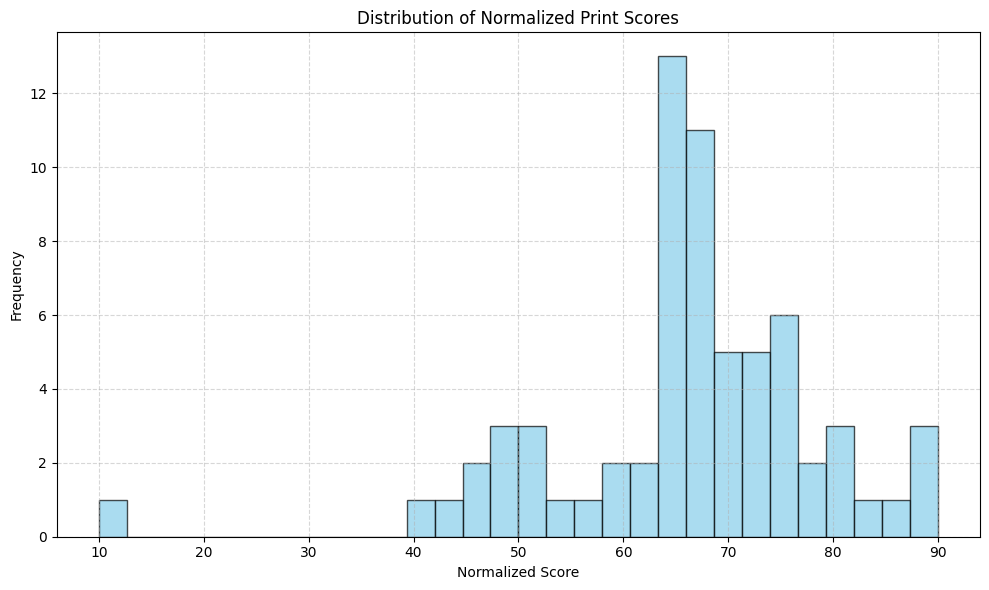

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(valid_rows['Normalized_Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Normalized Print Scores')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Distribution of Print Quality Scores.png')
plt.show()


C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


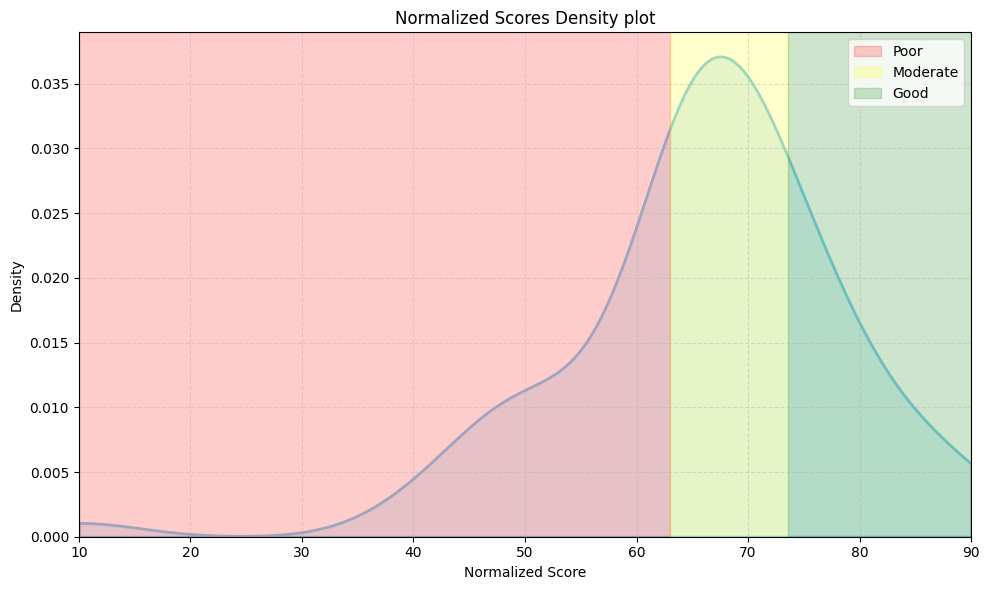

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine thresholds
good_threshold = valid_rows['Normalized_Score'].quantile(0.75)
bad_threshold = valid_rows['Normalized_Score'].quantile(0.25)

plt.figure(figsize=(10, 6))

# KDE plot
sns.kdeplot(valid_rows['Normalized_Score'], fill=True, color='skyblue', linewidth=2, clip=(10, 90))

# Highlight Good / Average / Bad zones
plt.axvspan(10, bad_threshold, color='red', alpha=0.2, label='Poor')
plt.axvspan(bad_threshold, good_threshold, color='yellow', alpha=0.2, label='Moderate')
plt.axvspan(good_threshold, 90, color='green', alpha=0.2, label='Good')

# Plot formatting
plt.xlim(10, 90)
plt.xlabel('Normalized Score')
plt.ylabel('Density')
plt.title('Normalized Scores Density plot')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig('density_plot_scores.png')
plt.show()


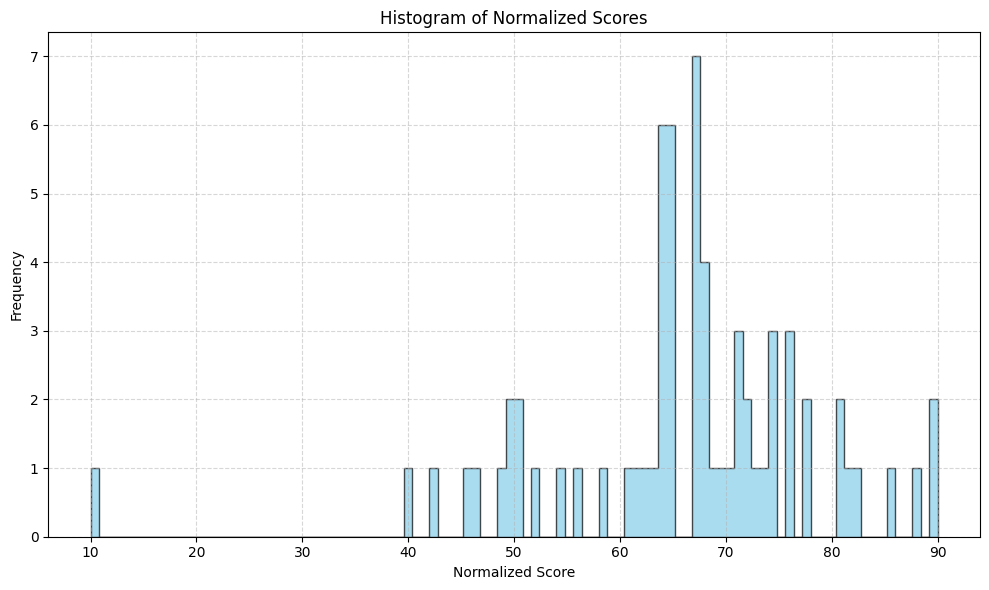

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(valid_rows['Normalized_Score'], bins=100, color='skyblue', edgecolor='black', alpha=0.7, histtype='stepfilled')
plt.title('Histogram of Normalized Scores')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Histogram_normalized scores.png')
plt.show()


# Printability Map Try 2

C:\Users\Ahmad\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in classify_score (vectorized)
  outputs = ufunc(*inputs)


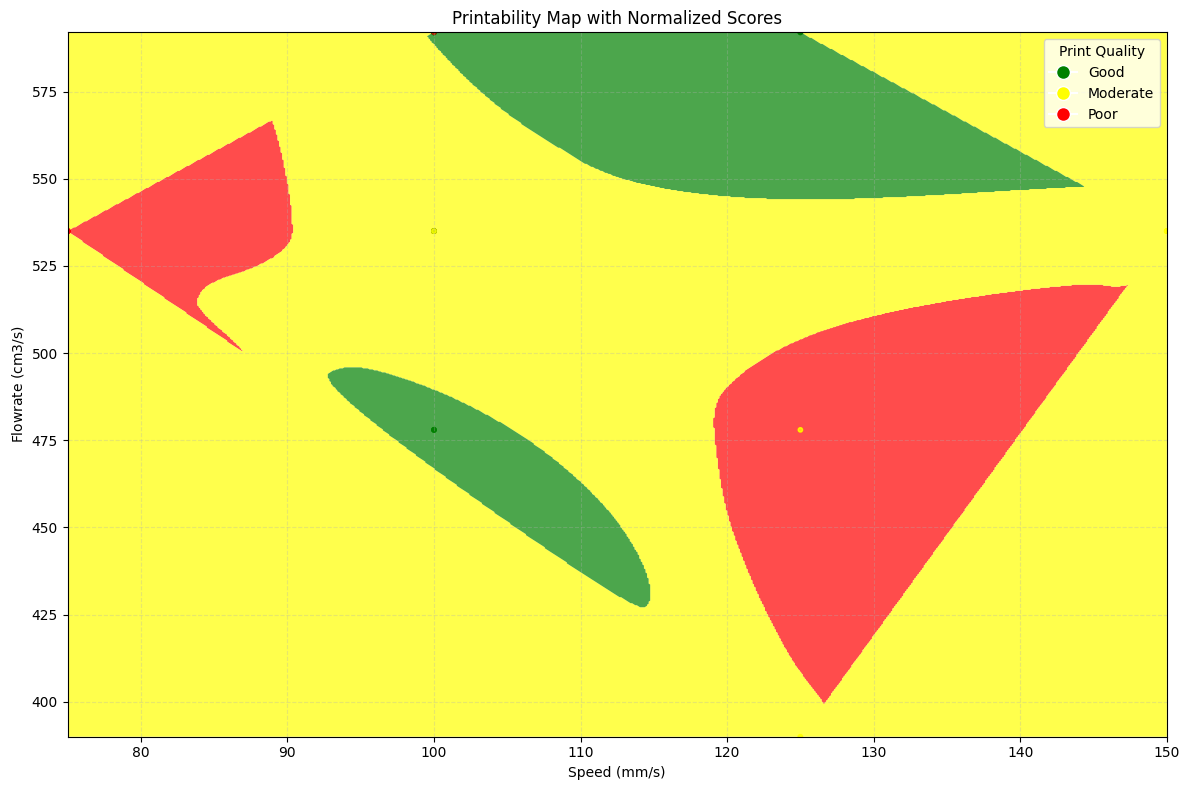

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from matplotlib.colors import ListedColormap

# Load the dataset
data = pd.read_csv('classified_print_quality_final.csv')

# Prepare the data
x = data['Speed (mm/s)'].values
y = data['Flowrate (cm^3/s)'].values
z = data['Normalized_Score'].values
labels = data['Print_Quality'].values

# Create high-res grid
xi = np.linspace(x.min(), x.max(), 700)
yi = np.linspace(y.min(), y.max(), 700)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate normalized scores onto grid
zi = griddata((x, y), z, (xi_grid, yi_grid), method='cubic')

# Classify interpolated scores into Good (2), Average (1), Bad (0)
def classify_score(score):
    if score >= data['Normalized_Score'].quantile(0.75):
        return 2  # Good (green)
    elif score <= data['Normalized_Score'].quantile(0.25):
        return 0  # Bad (red)
    else:
        return 1  # Average (yellow)

# Apply classification across interpolated grid
zi_class = np.vectorize(classify_score)(zi)

# Define discrete colormap
cmap = ListedColormap(['red', 'yellow', 'green'])

# Plot the printability map
plt.figure(figsize=(12, 8))
plt.contourf(xi_grid, yi_grid, zi_class, levels=[-0.5, 0.5, 1.5, 2.5], cmap=cmap, alpha=0.7, antialiased=True)

# Remove black dots by omitting edgecolor
plt.scatter(x, y, c=[{'Poor Print':'red', 'Moderate Print':'yellow', 'Good Print':'green'}[label] for label in labels],
            s=10, label='Data Points', alpha=0.6)

# Labels and legend
plt.xlabel('Speed (mm/s)')
plt.ylabel('Flowrate (cm$3$/s)')
plt.title('Printability Map with Normalized Scores')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Good', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Moderate', markerfacecolor='yellow', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Poor', markerfacecolor='red', markersize=10)
]
plt.legend(handles=handles, title='Print Quality', loc='upper right')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('printability map.png')
plt.show()


# EDA

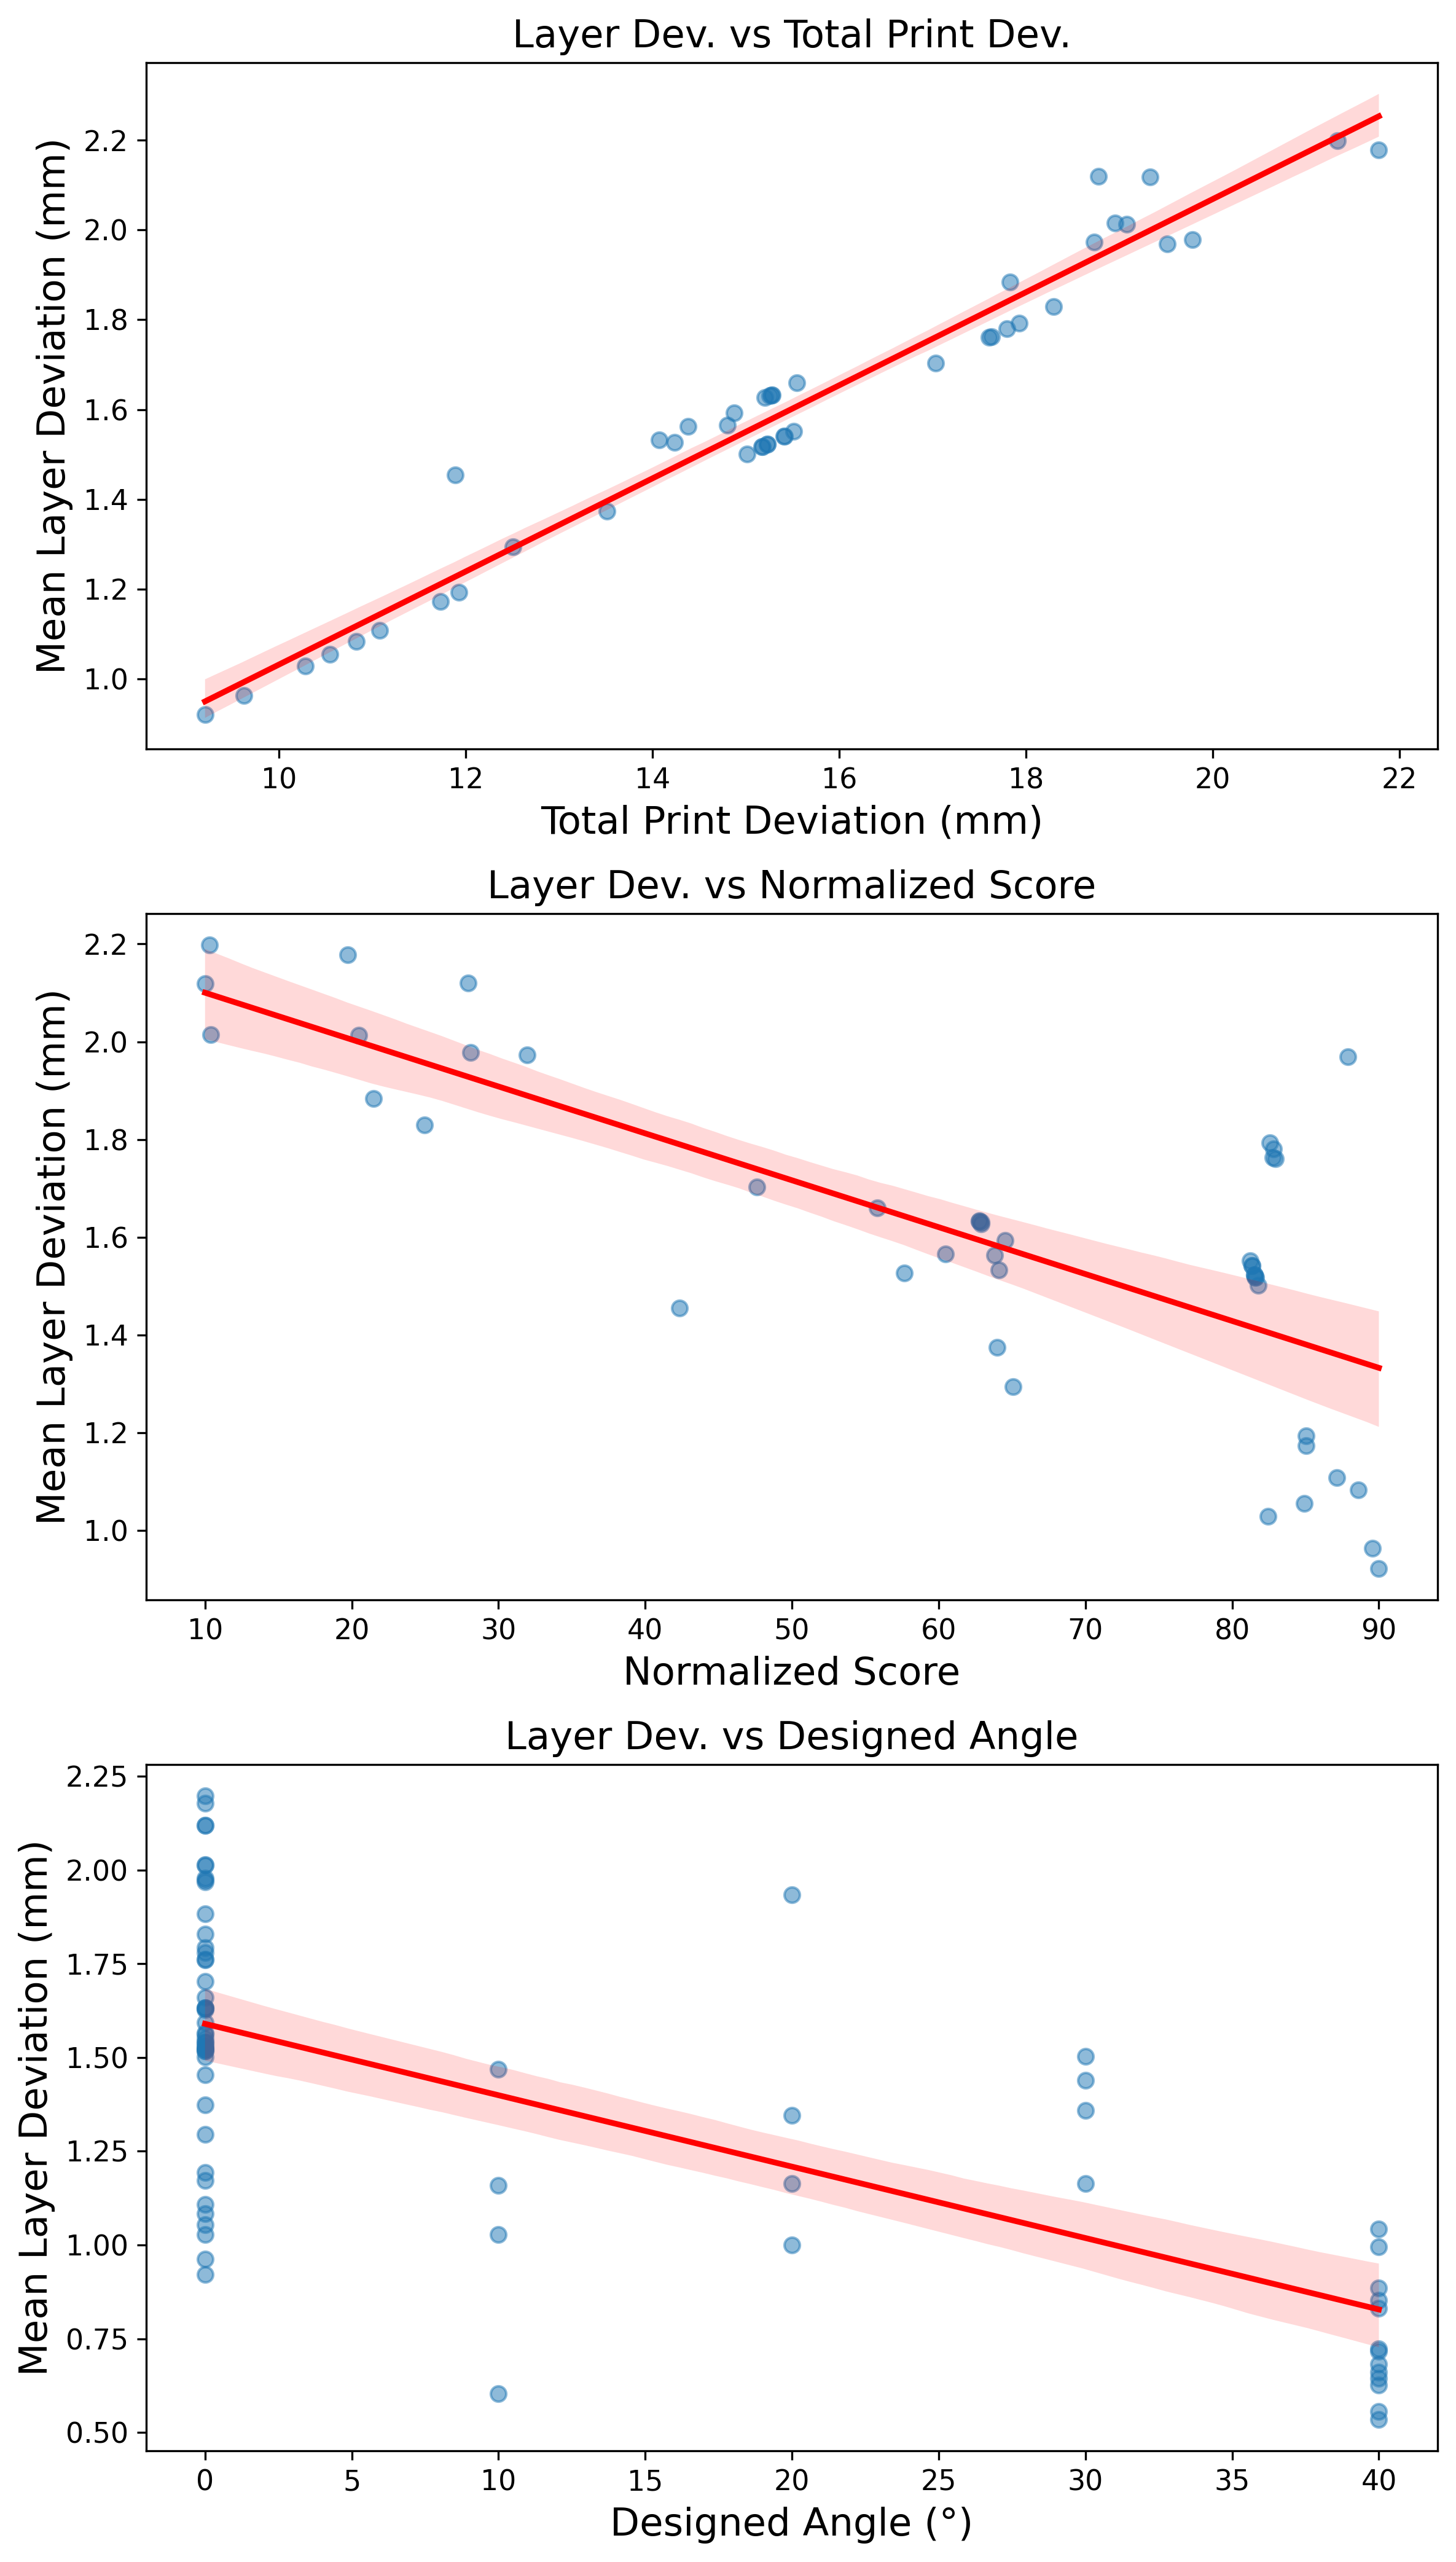

In [10]:
# Reload the correctly referenced dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the dataset
data = pd.read_csv('data_with_metrics.csv')
data['Angle_dev (deg)'] = pd.to_numeric(data['Angle_dev (deg)'], errors='coerce')
layer_dev_columns = [col for col in data.columns if "Layer" in col and "Deviation" in col]
data['Mean Layer Deviation'] = data[layer_dev_columns].mean(axis=1)

# Clean the data for plotting
data_clean = data.dropna(subset=[
    'Angle_dev (deg)',
    'total_print_deviation',
    'Normalized_Score',
    'Designed Angle (deg)'
])

# Create vertically stacked version of the exact same plot
fig, axes = plt.subplots(3, 1, figsize=(8, 14), dpi=300)

# Plot 1: Mean Layer Deviation vs Total Print Deviation
sns.regplot(x='total_print_deviation', y='Mean Layer Deviation', data=data_clean,
            ax=axes[0], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=95)
axes[0].set_title("Layer Dev. vs Total Print Dev.", fontsize=15)
axes[0].set_xlabel("Total Print Deviation (mm)", fontsize=15)
axes[0].set_ylabel("Mean Layer Deviation (mm)", fontsize=15)
axes[0].tick_params(labelsize=11)

# Plot 2: Mean Layer Deviation vs Normalized Score
sns.regplot(x='Normalized_Score', y='Mean Layer Deviation', data=data_clean,
            ax=axes[1], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=95)
axes[1].set_title("Layer Dev. vs Normalized Score", fontsize=15)
axes[1].set_xlabel("Normalized Score", fontsize=15)
axes[1].set_ylabel("Mean Layer Deviation (mm)", fontsize=15)
axes[1].tick_params(labelsize=11)

# Plot 3: Mean Layer Deviation vs Designed Angle
sns.regplot(x='Designed Angle (deg)', y='Mean Layer Deviation', data=data,
            ax=axes[2], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=95)
axes[2].set_title("Layer Dev. vs Designed Angle", fontsize=15)
axes[2].set_xlabel("Designed Angle (°)", fontsize=15)
axes[2].set_ylabel("Mean Layer Deviation (mm)", fontsize=15)
axes[2].tick_params(labelsize=11)

# Final layout and export
plt.tight_layout()
final_vertical_plot_path = "combined_vertical_regression_plots.png"
plt.savefig(final_vertical_plot_path, dpi=300)
plt.show()
